In [17]:
%load_ext autoreload
%autoreload 2
%aimport -numpy, -matplotlib, -IPython
from IPython.display import display
import l2a_analysis as l2aa
from helpers import get_stats_average, plot_true_color_image, plot_difference_histogram, multiplot_difference_histogram



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
locs = {
    "CH": "S2A_MSIL1C_20230903T101601_N0509_R065_T32TMS_20230903T140124.SAFE",
    "BRA": "S2A_MSIL1C_20230909T141721_N0509_R010_T21MTS_20230909T192148.SAFE",
    'ALG' : 'S2B_MSIL1C_20230904T103629_N0509_R008_T30RXT_20230904T125735.SAFE'
}

# NO_DATA, SATURATED_OR_DEFECTIVE, CASTED_SHADOWS, CLOUD_SHADOWS, VEGETATION, NOT_VEGETATED, WATER, UNCLASSIFIED, CLOUD_MEDIUM_PROBABILITY, CLOUD_HIGH_PROBABILITY, THIN_CIRRUS, SNOW
SC_const_labels = [
    {
        'flag' : 'SEN2COR_MOD_const_class',
        'value' : '0',
        'info' : 'Set whole SCL layer to NO_DATA',
        'name' : 'class_NO_DATA'
    },
    # {
    #     'flag' : 'SEN2COR_MOD_const_class',
    #     'value' : '1',
    #     'info' : 'Set whole SCL layer to SATURATED_OR_DEFECTIVE',
    #     'name' : 'class_SATURATED_OR_DEFECTIVE'
    # },
    {
        'flag' : 'SEN2COR_MOD_const_class',
        'value' : '2',
        'info' : 'Set whole SCL layer to CASTED_SHADOWS',
        'name' : 'class_CASTED_SHADOWS'
    },
    {
        "flag": "SEN2COR_MOD_const_class",
        "value": "3",
        "info": "Set whole SCL layer to CLOUD_SHADOWS",
        "name": "class_CLOUD_SHADOWS",
    },
    {
        "flag": "SEN2COR_MOD_const_class",
        "value": "4",
        "info": "Set whole SCL layer to VEGETATION",
        "name": "class_VEGETATION",
    },
    {
        'flag' : 'SEN2COR_MOD_const_class',
        'value' : '5',
        'info' : 'Set whole SCL layer to NOT_VEGETATED',
        'name' : 'class_NOT_VEGETATED'
    },
    {
        'flag' : 'SEN2COR_MOD_const_class',
        'value' : '6',
        'info' : 'Set whole SCL layer to WATER',
        'name' : 'class_WATER'
    },
    {
        'flag' : 'SEN2COR_MOD_const_class',
        'value' : '7',
        'info' : 'Set whole SCL layer to UNCLASSIFIED',
        'name' : 'class_UNCLASSIFIED'
    },
    {
        'flag' : 'SEN2COR_MOD_const_class',
        'value' : '8',
        'info' : 'Set whole SCL layer to CLOUD_MEDIUM_PROBABILITY',
        'name' : 'class_CLOUD_MEDIUM_PROBABILITY'
    },
    {
        'flag' : 'SEN2COR_MOD_const_class',
        'value' : '9',
        'info' : 'Set whole SCL layer to CLOUD_HIGH_PROBABILITY',
        'name' : 'class_CLOUD_HIGH_PROBABILITY'
    },
    {
        'flag' : 'SEN2COR_MOD_const_class',
        'value' : '10',
        'info' : 'Set whole SCL layer to THIN_CIRRUS',
        'name' : 'class_THIN_CIRRUS'
    },
    {
        'flag' : 'SEN2COR_MOD_const_class',
        'value' : '11',
        'info' : 'Set whole SCL layer to SNOW',
        'name' : 'class_SNOW'
    },
]

In [19]:
l2a_analysis = l2aa.L2A_Analysis()
l2a_analysis.set_locations(locs)
l2a_analysis.set_modifications(SC_const_labels)

In [20]:

l2a_analysis.run_sen2cor()
l2a_analysis.read_l2a_data()

CH:	reference already exists. Skipping...
BRA:	reference already exists. Skipping...
ALG:	reference already exists. Skipping...
CH:	class_NO_DATA already exists. Skipping...
BRA:	class_NO_DATA already exists. Skipping...
ALG:	class_NO_DATA already exists. Skipping...
CH:	class_CASTED_SHADOWS already exists. Skipping...
BRA:	class_CASTED_SHADOWS already exists. Skipping...
ALG:	class_CASTED_SHADOWS already exists. Skipping...
CH:	class_CLOUD_SHADOWS already exists. Skipping...
BRA:	class_CLOUD_SHADOWS already exists. Skipping...
ALG:	class_CLOUD_SHADOWS already exists. Skipping...
CH:	class_VEGETATION already exists. Skipping...
BRA:	class_VEGETATION already exists. Skipping...
ALG:	class_VEGETATION already exists. Skipping...
CH:	class_NOT_VEGETATED already exists. Skipping...
BRA:	class_NOT_VEGETATED already exists. Skipping...
ALG:	class_NOT_VEGETATED already exists. Skipping...
CH:	class_WATER already exists. Skipping...
BRA:	class_WATER already exists. Skipping...
ALG:	class_WATER 

Max value: 0.51556396484375


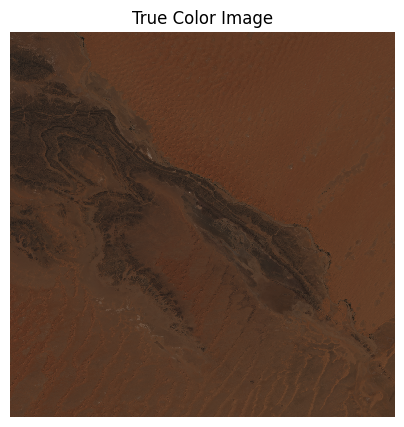

In [21]:
plot_true_color_image(l2a_analysis.reference_bands['ALG'])

In [22]:
loc = 'CH'
mod = 'class_NO_DATA'
stat_bands = ["B02", "B03", "B04", "B05", "B06", "B07", "B8A", "B11", "B12"]
stats = get_stats_average(l2a_analysis.reference_bands[loc], l2a_analysis.modified_bands[loc][mod], stat_bands)
display(stats)



mean       9.621222
std      161.361465
max     2031.222168
min    -4684.888672
dtype: float32

In [23]:
locs = ['ALG', 'CH', 'BRA']
bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B8A', 'B11', 'B12']
mod = 'class_VEGETATION'
# for loc in locs:
#     plot_title = f"Difference Histogram for {loc} with {mod}"
#     plot_difference_histogram(l2a_analysis.reference_bands[loc],l2a_analysis.modified_bands[loc][mod],bands,plot_title=plot_title)

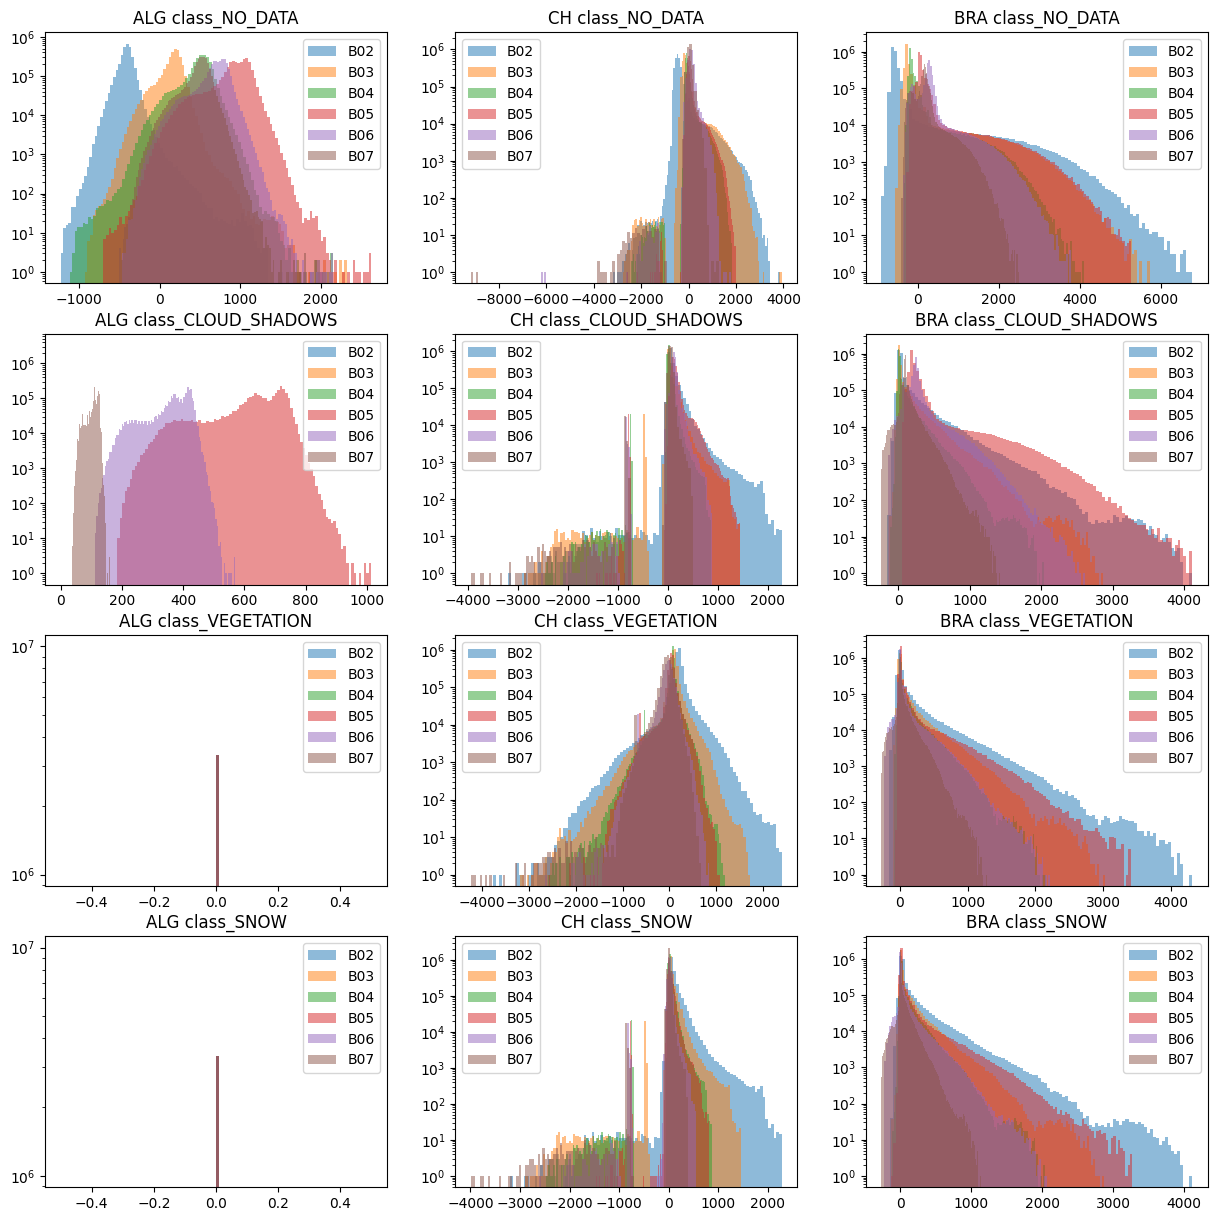

In [24]:

locs = ['ALG', 'CH', 'BRA']
bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07']
mods = ['class_NO_DATA',  'class_CLOUD_SHADOWS', 'class_VEGETATION', 'class_SNOW']
multiplot_difference_histogram(l2a_analysis, locs, mods, bands)

In [25]:
from helpers import get_stats_average_multi
locs = ['ALG', 'CH', 'BRA']
mods = ['class_NO_DATA',  'class_CLOUD_SHADOWS', 'class_VEGETATION', 'class_SNOW']
bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07']
stats = get_stats_average_multi(l2a_analysis, locs, mods, bands)
display(stats['std'])

,class_NO_DATA,class_CLOUD_SHADOWS,class_VEGETATION,class_SNOW
ALG,170.074631,32.398178,0.000000,0.000000
CH,207.096863,106.217735,141.408936,93.615997
BRA,414.881622,176.363205,160.896164,147.621170


In [26]:
display(stats['max'].transpose())

,ALG,CH,BRA
class_NO_DATA,2185.166748,2448.000000,4691.166504
class_CLOUD_SHADOWS,290.666656,1240.666626,2859.000000
class_VEGETATION,0.000000,1322.000000,2731.833252
class_SNOW,0.000000,1059.333374,2580.166748
